# FraudLens Model Training
This notebook loads Facebook-scraped datasets, preprocesses posts and reviews, and trains a hybrid model using TF-IDF + Isolation Forest.

In [1]:

import os
import json
import re
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import IsolationForest
import joblib

# Define dataset directory
data_dir = Path("..") / "data"
combined_df = []
reviews_corpus = []
print("All JSON files in data/:", list(data_dir.glob("*.json")))
print("path is:", data_dir)

matching_files = list(data_dir.glob("final_scraped_dataset_*.json"))
print("Matching files:", matching_files)

for file in matching_files:
    try:
        with open(file, "r", encoding="utf-8") as f:
            data = json.load(f)

            # ✅ Safely load posts
            posts = data.get("Posts", [])
            if isinstance(posts, list) and all(isinstance(p, dict) for p in posts):
                posts_df = pd.DataFrame(posts)
                posts_df["About"] = [data.get("About", "")] * len(posts_df)
                posts_df["Recommendation"] = [data.get("Recommendation", "")] * len(posts_df)
                combined_df.append(posts_df)
            else:
                print(f"⚠️ Skipping file (invalid Posts list): {file.name}")

            # ✅ Collect all review strings
            for r in data.get("Reviews", []):
                if isinstance(r, dict) and r.get("Review"):
                    reviews_corpus.append(r["Review"])

    except Exception as e:
        print(f"❌ Error reading {file.name}: {e}")





df = pd.concat(combined_df, ignore_index=True) if combined_df else pd.DataFrame()
print("✅ Total posts loaded:", len(df))


All JSON files in data/: [WindowsPath('../data/final_scraped_dataset_100079608703063.json'), WindowsPath('../data/final_scraped_dataset_apexlaptops.json'), WindowsPath('../data/final_scraped_dataset_cartpet_republic.json'), WindowsPath('../data/final_scraped_dataset_doctormobile.json'), WindowsPath('../data/final_scraped_dataset_geniusmobile.json'), WindowsPath('../data/final_scraped_dataset_kingsmobile.json'), WindowsPath('../data/final_scraped_dataset_lankausedlaptops.json'), WindowsPath('../data/final_scraped_dataset_laprepairing.json'), WindowsPath('../data/final_scraped_dataset_mastermobile.json'), WindowsPath('../data/final_scraped_dataset_phonedoctor.json'), WindowsPath('../data/final_scraped_dataset_shoeslk.json'), WindowsPath('../data/final_scraped_dataset_SLPHONES.json'), WindowsPath('../data/final_scraped_dataset_sneakersclub_updated.json'), WindowsPath('../data/final_scraped_dataset_temu.json'), WindowsPath('../data/final_scraped_dataset_uniquelaptops.json')]
path is: ..\da

In [2]:

def clean_text(text):
    text = text.lower()
    text = re.sub(r'… see more', '', text)
    text = re.sub(r'http\S+', '', text)
    text = re.sub(r'[^a-z0-9\s]', '', text)
    return text.strip()

def preprocess(df):
    df['Cleaned Content'] = df['Post Content'].fillna("").apply(clean_text)
    df['Post Length'] = df['Cleaned Content'].apply(len)
    df['Num Comments'] = df['Comments'].apply(len)
    df['Total Reactions'] = df['Reactions'].apply(lambda x: sum(x.values()) if isinstance(x, dict) else 0)
    df['Angry Ratio'] = df['Reactions'].apply(lambda x: x.get('Angry', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Sad Ratio'] = df['Reactions'].apply(lambda x: x.get('Sad', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Haha Ratio'] = df['Reactions'].apply(lambda x: x.get('Haha', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    df['Love Ratio'] = df['Reactions'].apply(lambda x: x.get('Love', 0) / sum(x.values()) if sum(x.values()) > 0 else 0)
    return df

if not df.empty:
    df = preprocess(df)
    print("✅ Preprocessing complete.")
    display(display(df))
else:
    print("⚠️ No data to preprocess.")


✅ Preprocessing complete.


,Post Content,Comments,Reactions,Timestamp,About,Recommendation,Cleaned Content,Post Length,Num Comments,Total Reactions,Angry Ratio,Sad Ratio,Haha Ratio,Love Ratio
0,Sale Sale … See more,[],{},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,0,0.000000,0.000000,0.000000,0.000000
1,Sale Sale … See more,[],{},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,0,0.000000,0.000000,0.000000,0.000000
2,Sale Sale … See more,[],{},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,0,0.000000,0.000000,0.000000,0.000000
3,Sale Sale … See more,[],{'Like': 8},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,8,0.000000,0.000000,0.000000,0.000000
4,Happy Customer Happy New Year,[],{'Like': 3},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,happy customer happy new year,30,0,3,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
286,Best Laptop deals Please call or text 0772 163...,[],"{'Angry': 55, 'Sad': 35}",2024-05-31T20:08:32.649369,"{'Address': 'Attidiya, Sri Lanka', 'Contact': ...",90% recommend (22 Reviews),best laptop deals please call or text 0772 163...,111,0,90,0.611111,0.388889,0.000000,0.000000
287,New Arrivals LG Gram Thin and Light Laptop (T...,[],"{'Angry': 0, 'Wow': 5, 'Care': 63, 'Sad': 43, ...",2025-02-27T16:13:38.649389,"{'Address': 'Attidiya, Sri Lanka', 'Contact': ...",90% recommend (22 Reviews),new arrivals lg gram thin and light laptop to...,75,0,223,0.000000,0.192825,0.147982,0.000000
288,"Thinkpad X1 carbon i7-11 GenPrice:400,000Tech ...",[Still available?],"{'Like': 72, 'Love': 237, 'Sad': 112, 'Care': ...",2025-01-05T01:01:06.649416,"{'Address': 'Attidiya, Sri Lanka', 'Contact': ...",90% recommend (22 Reviews),thinkpad x1 carbon i711 genprice400000tech spe...,181,1,734,0.088556,0.152589,0.042234,0.322888
289,No Text,[],"{'Wow': 19, 'Sad': 26, 'Care': 28, 'Love': 17,...",2024-04-28T19:57:42.649465,"{'Address': 'Attidiya, Sri Lanka', 'Contact': ...",90% recommend (22 Reviews),no text,7,0,125,0.104000,0.208000,0.000000,0.136000


None

In [3]:

# Train TF-IDF + Logistic Regression
tfidf = TfidfVectorizer(max_features=100)
X_reviews = tfidf.fit_transform(reviews_corpus + df['Cleaned Content'].tolist())
dummy_labels = [0] * len(reviews_corpus) + [1] * len(df)
clf_text = LogisticRegression().fit(X_reviews, dummy_labels)

X_text = tfidf.transform(df['Cleaned Content'])
df['Text_Prob'] = clf_text.predict_proba(X_text)[:, 1]

# Anomaly Detection
features = ['Post Length', 'Num Comments', 'Total Reactions', 'Angry Ratio', 'Sad Ratio', 'Haha Ratio', 'Love Ratio']
X_behavior = df[features].fillna(0)
anomaly_model = IsolationForest(contamination=0.25, random_state=42)
df['Anomaly_Score'] = -anomaly_model.fit(X_behavior).decision_function(X_behavior)

# Final Score + Export
np.random.seed(42)
df['Trust_Score'] = np.random.uniform(0.5, 1.0, len(df))
df['FraudLens_Score'] = 0.4 * df['Text_Prob'] + 0.4 * df['Anomaly_Score'] + 0.2 * (1 - df['Trust_Score'])
df['Fraud_Prediction'] = df['FraudLens_Score'].apply(lambda x: 1 if x > 0.5 else 0)

# Export
df.to_csv("fraudlens_training_output.csv", index=False)
joblib.dump(tfidf, "tfidf_model.pkl")
joblib.dump(clf_text, "logistic_model.pkl")
joblib.dump(anomaly_model, "isolation_model.pkl")
print("✅ Models and results saved.")

print("✅ Training complete. Showing top suspicious posts:")
df[df['Fraud_Prediction'] == 1][['Post Content', 'FraudLens_Score', 'Text_Prob', 'Anomaly_Score']]


✅ Models and results saved.
✅ Training complete. Showing top suspicious posts:


C:\Users\hgamage\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\sklearn\base.py:451: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  "X does not have valid feature names, but"


,Post Content,FraudLens_Score,Text_Prob,Anomaly_Score


In [4]:
!pip install seaborn
!pip install sentence-transformers
!pip install altair

C:\Users\hgamage\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


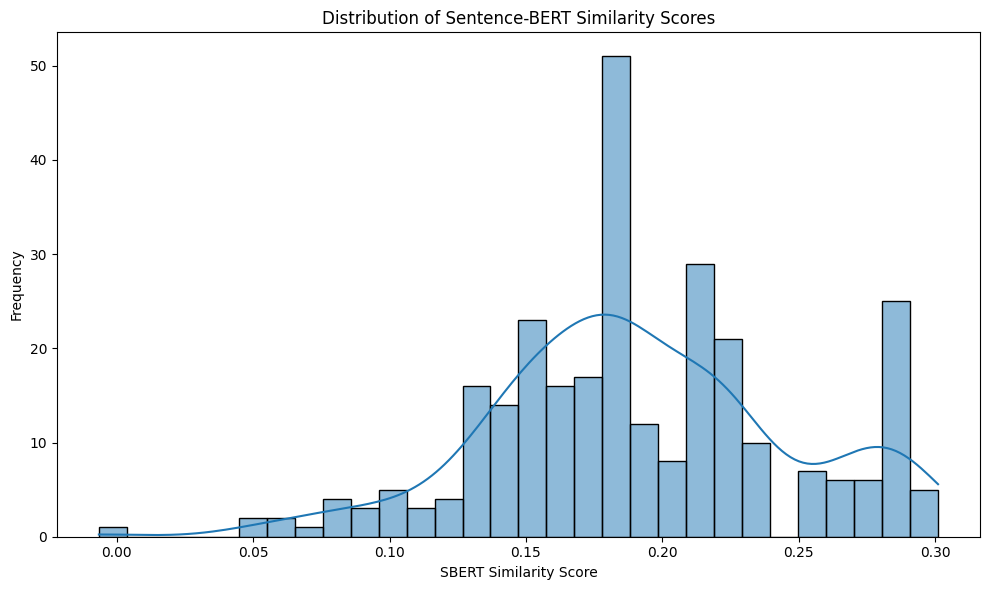

In [5]:
from sentence_transformers import SentenceTransformer, util
import matplotlib.pyplot as plt
import seaborn as sns

# Load Sentence-BERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Encode post content with Sentence-BERT
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), convert_to_tensor=True)

# Compute pairwise cosine similarities
cosine_scores = util.pytorch_cos_sim(sbert_embeddings, sbert_embeddings)

# Average similarity for each post
df['SBERT_Similarity'] = cosine_scores.mean(dim=1).cpu().numpy()

# Visualize distribution
plt.figure(figsize=(10, 6))
sns.histplot(df['SBERT_Similarity'], bins=30, kde=True)
plt.title("Distribution of Sentence-BERT Similarity Scores")
plt.xlabel("SBERT Similarity Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


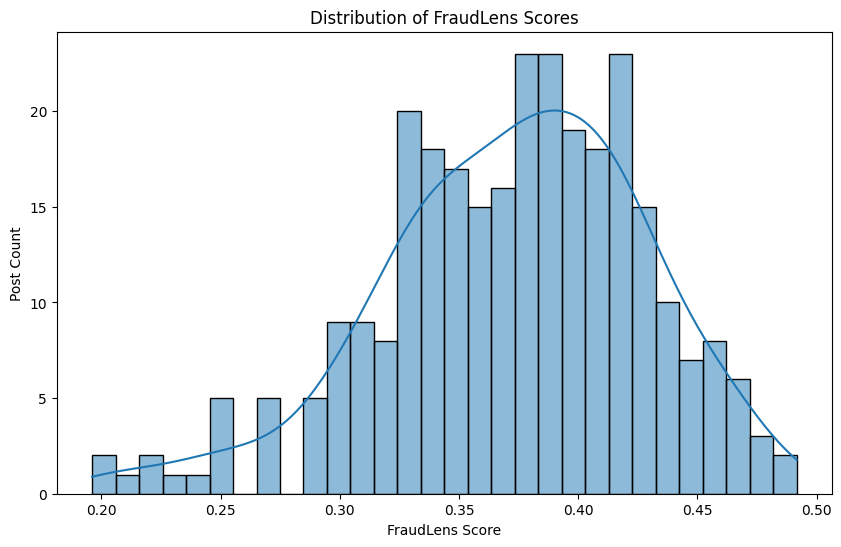

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['FraudLens_Score'], bins=30, kde=True)
plt.title("Distribution of FraudLens Scores")
plt.xlabel("FraudLens Score")
plt.ylabel("Post Count")
plt.show()

### 🔎 Sentence-BERT Vectorization for Semantic Features

In [7]:
from sentence_transformers import SentenceTransformer

# Load a pre-trained Sentence-BERT model
sbert_model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate embeddings for post content
sbert_embeddings = sbert_model.encode(df['Cleaned Content'].tolist(), show_progress_bar=True)

# Convert to DataFrame
import numpy as np
sbert_df = pd.DataFrame(sbert_embeddings, columns=[f'sbert_{i}' for i in range(sbert_embeddings.shape[1])])
df = pd.concat([df.reset_index(drop=True), sbert_df.reset_index(drop=True)], axis=1)
print("✅ SBERT vectors added to DataFrame")
df.head()


Batches: 100%|██████████| 10/10 [00:03<00:00,  3.33it/s]

✅ SBERT vectors added to DataFrame


,Post Content,Comments,Reactions,Timestamp,About,Recommendation,Cleaned Content,Post Length,Num Comments,Total Reactions,...,sbert_374,sbert_375,sbert_376,sbert_377,sbert_378,sbert_379,sbert_380,sbert_381,sbert_382,sbert_383
0,Sale Sale … See more,[],{},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,0,...,-0.041654,0.005963,-0.013378,-0.000467,0.017885,0.056026,0.014115,-0.054798,-0.072833,0.046893
1,Sale Sale … See more,[],{},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,0,...,-0.041654,0.005963,-0.013378,-0.000467,0.017885,0.056026,0.014115,-0.054798,-0.072833,0.046893
2,Sale Sale … See more,[],{},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,0,...,-0.041654,0.005963,-0.013378,-0.000467,0.017885,0.056026,0.014115,-0.054798,-0.072833,0.046893
3,Sale Sale … See more,[],{'Like': 8},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,sale sale,9,0,8,...,-0.041654,0.005963,-0.013378,-0.000467,0.017885,0.056026,0.014115,-0.054798,-0.072833,0.046893
4,Happy Customer Happy New Year,[],{'Like': 3},Unknown,"{'Address': 'Dehiwela, Colombo, Sri Lanka, 103...",96% recommend (571 reviews)﻿,happy customer happy new year,30,0,3,...,-0.009951,-0.016130,-0.012160,0.039523,-0.000819,0.043056,0.013129,0.041918,0.035028,0.034247


### 📊 Visualize Fraud Scores

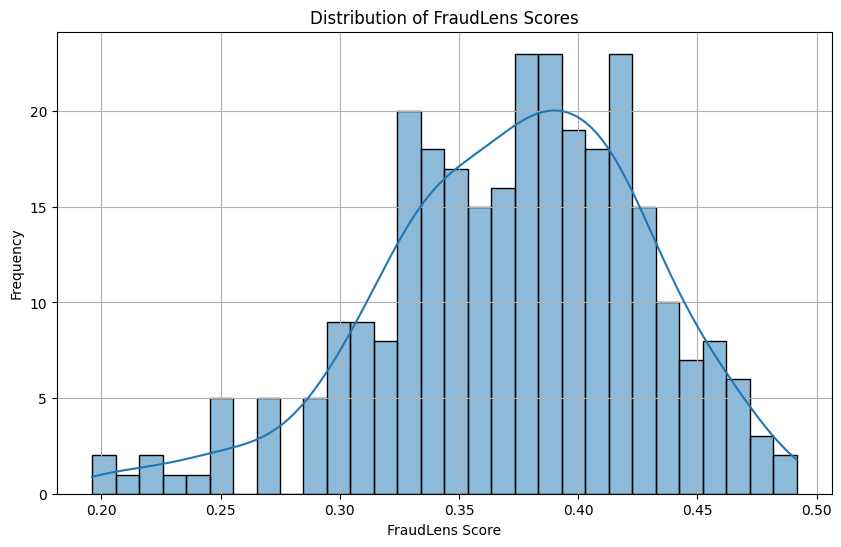

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(df['FraudLens_Score'], bins=30, kde=True)
plt.title("Distribution of FraudLens Scores")
plt.xlabel("FraudLens Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


### 🔐 Blockchain-Based Identity Verification (Pseudocode)

In [9]:
# Pseudocode: Blockchain for Identity Verification

class DecentralizedIdentity:
    def __init__(self, user_id):
        self.did = self.generate_did(user_id)
        self.reputation = 100
    
    def generate_did(self, user_id):
        import hashlib
        return hashlib.sha256(user_id.encode()).hexdigest()
    
    def flag_user(self, reason):
        self.reputation -= 10
        self.log_to_blockchain(reason)
    
    def log_to_blockchain(self, reason):
        print(f"📜 Logging: {self.did} flagged for {reason}")

# Example usage
user = DecentralizedIdentity("fraudulent_user@example.com")
user.flag_user("Suspicious posting behavior")


📜 Logging: 054d9406110e202ec1eaa0b551ef1001ffb1374df76c4c37c972f62b2d10c395 flagged for Suspicious posting behavior
